In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imshow
import pandas as pd
from sklearn.model_selection import train_test_split
import skimage

/home/wvillegas/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
use_gpu = torch.cuda.is_available()

In [3]:
use_gpu

True

In [4]:
dataset = pd.read_csv(os.path.join('/home','wvillegas','dataset-mask', 'full_masks.csv'))
root_dir = os.path.join('/home','wvillegas','dataset-mask')

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset['orig'],dataset['mask'],
                                                    test_size = 0.2, random_state=1)
partition = {'train':list(X_train),
             'test': list(X_test)}
img_list = list(X_train) + list(X_test)
mask_list = list(Y_train) + list(Y_test)
labels = dict(zip(img_list, mask_list))

In [6]:
from utils_pytorch import BudMaskDataset

In [7]:
data_train = BudMaskDataset(img_list=partition['train'], labels=labels, root_dir=root_dir)

In [8]:
temp = data_train.__getitem__(0);

In [9]:
img = temp['image']

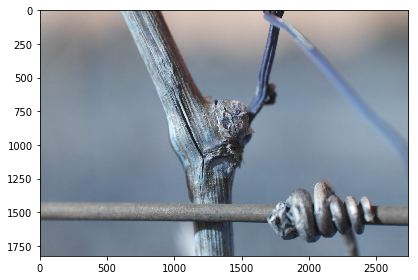

In [10]:
imshow(img)

/home/wvillegas/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


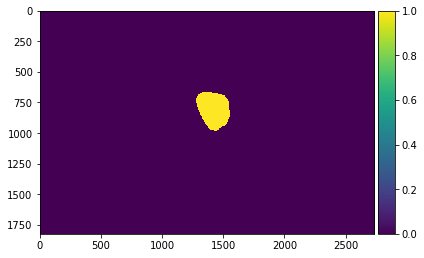

In [11]:
imshow(temp['mask'])

In [12]:
class VGG11_BN_FCN(nn.Module):
    def __init__(self):
        super().__init__()
        vgg11_bn = models.vgg11_bn(pretrained=True)
        self.encoder = vgg11_bn.features
        self.decoder = nn.Sequential(nn.Conv2d(in_channels=512,out_channels=256,kernel_size=1),
                                     nn.Conv2d(in_channels=256,out_channels=1,kernel_size=1),
                                     nn.ConvTranspose2d(in_channels=1,out_channels=1, kernel_size=16, stride=8),
                                     nn.ConvTranspose2d(in_channels=1,out_channels=1, kernel_size=4, stride=2),
                                     nn.ConvTranspose2d(in_channels=1,out_channels=1, kernel_size=4, stride=2))
        
    def forward(self, x):
        x = self.encoder.forward(x)
#         print(x.shape)
        x = self.decoder.forward(x)
#         print(x.shape)
        return x
            #return self.encoder.forward(x)

In [13]:
fcn_encoder = VGG11_BN_FCN()

In [14]:
fcn_encoder.modules

<bound method Module.modules of VGG11_BN_FCN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
  

In [15]:
fcn_encoder = fcn_encoder.cuda()

In [16]:
img = torch.unsqueeze(torch.from_numpy(img), 0)

In [17]:
img.shape

torch.Size([1, 1824, 2736, 3])

In [18]:
img = img.permute(0,3,1,2)

In [19]:
img = img.type(torch.FloatTensor)
img = img.cuda()

In [20]:
res = fcn_encoder.forward(img)

torch.Size([1, 512, 57, 85])
torch.Size([1, 1, 1862, 2758])
